Autor: Rodrigo Stuckert. Data: 2020-06-23

# Análise da Covid-19 no Distrito Federal

Este código foi feito para analisar os casos da covid-19 no Distrito Federal (DF). Os dados aqui utilizados são referentes ao dia 2020-07-21 12:00, e foram extraídos a partir da seguinte página: https://covid19.ssp.df.gov.br/extensions/covid19/covid19.html#/

Cabe salientar que, a partir do dia 2020-07-09, houve uma alteração na disposição dos dados. Removeu-se o número de identificação de cada pessoa (**id**); adicionou-se uma nova variável, **dataPrimeirosintomas**, indicando o início dos sintomas; e, por fim, substitui-se a variável **Estado de Saúde** por uma **Óbito**, indicando se a pessoa faleceu até aquele dia, ou não. De fato, para fins do painel de dados próprio, a Secretaria de Saúde (SESDF) considera como casos recuperados aqueles em que a pessoa não foi a óbito ou se internou após sete dias do diagnóstico. 

## Extração dos dados

Os pacotes aqui utilizados foram o dplyr e lubridate, para manipulação dos dados, e o ggplot2, para a elaboração dos gráficos. A função "options(warn = -1)" desativa as mensagens de aviso do R. Para voltar ao normal, basta usar "options(warn = 0)"

In [11]:
options(warn = -1)
library(dplyr)
library(lubridate) # Manipular datas
library(forcats) # Ordenar factors
library(ggplot2)
options(warn = 0)

Os dados estão no arquivo "dados-abertos.csv", dentro do diretório "datasets". Caso você queira baixar os dados mais recentes, no lugar, substitua essa referência pelo link mencionado abaixo. É importante ter em mente aqui que pode haver problemas de compatibilidade futuramente, caso a Secretaria de Saúde do DF (SESDF) eventualmente altere a disposição dos dados.

In [2]:
#link <- "https://covid19.ssp.df.gov.br/resources/dados/dados-abertos.csv"
arquivo <- "datasets/dados-abertos.csv"
df <- data.table::fread(arquivo, encoding = "UTF-8", 
                        col.names = c("Data", "DataCadastro", "Sexo",
                                      "FaixaEtaria", "RA", "UF", "Obito", "DataPrimeirosintomas",
                                      "Pneumopatia", "Nefropatia", "DHematologica",
                                      "DistMetabolico", "Imunopressao", "Obesidade",
                                      "Outros", "Cardiovasculopatia"),
                        colClasses = list(factor= c(3, 6)) # Colunas Sexo e UF como factors
                        )

Verificando a importação do arquivo.

In [3]:
str(df) # Estrutura
head(df) # Início
# tail(df) # Fim

Classes 'data.table' and 'data.frame':	84761 obs. of  16 variables:
 $ Data                : chr  "21/07/2020" "21/07/2020" "21/07/2020" "21/07/2020" ...
 $ DataCadastro        : chr  "18/03/2020" "18/03/2020" "18/03/2020" "18/03/2020" ...
 $ Sexo                : Factor w/ 2 levels "Feminino","Masculino": 2 2 2 2 1 1 1 1 2 1 ...
 $ FaixaEtaria         : chr  "50 a 59 anos" "50 a 59 anos" "40 a 49 anos" ">= 60 anos" ...
 $ RA                  : chr  "Plano Piloto" "Lago Sul" "Lago Sul" "Águas Claras" ...
 $ UF                  : Factor w/ 28 levels "","ACRE","ALAGOAS",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ Obito               : chr  "Não" "Não" "Não" "Não" ...
 $ DataPrimeirosintomas: chr  "23/04/2020" "29/03/2020" "09/03/2020" "14/03/2020" ...
 $ Pneumopatia         : chr  "" "Sim" "" "Não" ...
 $ Nefropatia          : chr  "" "Não" "" "Não" ...
 $ DHematologica       : chr  "" "Não" "" "Não" ...
 $ DistMetabolico      : chr  "" "Sim" "" "Sim" ...
 $ Imunopressao        : chr  "" "Não" "" "Nã

Data,DataCadastro,Sexo,FaixaEtaria,RA,UF,Obito,DataPrimeirosintomas,Pneumopatia,Nefropatia,DHematologica,DistMetabolico,Imunopressao,Obesidade,Outros,Cardiovasculopatia
21/07/2020,18/03/2020,Masculino,50 a 59 anos,Plano Piloto,DISTRITO FEDERAL,Não,23/04/2020,,,,,,,,
21/07/2020,18/03/2020,Masculino,50 a 59 anos,Lago Sul,DISTRITO FEDERAL,Não,29/03/2020,Sim,Não,Não,Sim,Não,Não,Não,Não
21/07/2020,18/03/2020,Masculino,40 a 49 anos,Lago Sul,DISTRITO FEDERAL,Não,09/03/2020,,,,,,,,
21/07/2020,18/03/2020,Masculino,>= 60 anos,Águas Claras,DISTRITO FEDERAL,Não,14/03/2020,Não,Não,Não,Sim,Não,Não,Não,Sim
21/07/2020,18/03/2020,Feminino,20 a 29 anos,Plano Piloto,DISTRITO FEDERAL,Não,14/03/2020,,,,,,,,
21/07/2020,16/03/2020,Feminino,30 a 39 anos,Plano Piloto,DISTRITO FEDERAL,Não,16/03/2020,,,,,,,,


## Tratamento dos dados

#### Datas e faixa etária

Uma vez que tudo está como deveria, podemos prosseguir com o tratamento dos dados. Primeiro iremos remover a data de extração dos dados, e depois corrigir o formato da data de cadastro dos casos.

In [4]:
# Pega a data de extração dos dados
extraction_date <- df$Data[1] %>%
  as.Date(format = '%d/%m/%Y')

# Remove a coluna com a data de extração e corrige o formato das demais datas.
df <- df %>%
    select(-c("Data")) %>%
    mutate(DataCadastro = as.Date(DataCadastro, format = '%d/%m/%Y'),
          DataPrimeirosintomas = as.Date(DataPrimeirosintomas, format = '%d/%m/%Y'))

# Verificando
class(df$DataCadastro)
head(df$DataCadastro)

[1] "Date"

[1] "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18"
[6] "2020-03-16"

Adaptando o nome dos inputs da variável FaixaEtaria para que possamos torná-la uma factor corretamente:

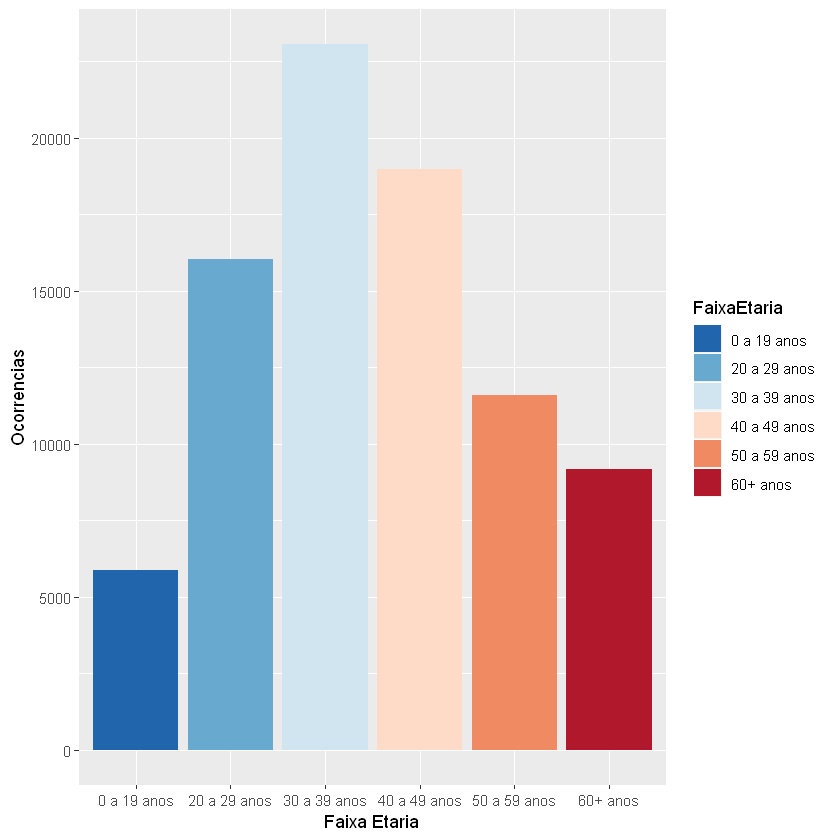

In [5]:
# Corrige os nomes das faixas etárias e torna a variável factor.
df <- df %>%
  mutate(FaixaEtaria = ifelse(FaixaEtaria == "<= 19 anos", "0 a 19 anos", FaixaEtaria),
         FaixaEtaria = ifelse(FaixaEtaria == ">= 60 anos", "60+ anos", FaixaEtaria),
         FaixaEtaria = as.factor(FaixaEtaria))

df %>%
  ggplot(aes(x = FaixaEtaria, fill = FaixaEtaria)) +
  geom_bar() +
  scale_fill_brewer(palette="RdBu", direction = -1) +
  labs(x = "Faixa Etaria", y = "Ocorrencias")

#### Comorbidades e óbitos

Devemos ter cautela especial quanto às variáveis de comorbidades. Inicialmente, pessoas com alguma comorbidade recebiam "Sim" para aquelas que apresentassem, e "Não" para todas as demais, enquanto que quem não apresentasse nenhuma aparecia como NA para todas. Após determinada data, o GDF passou a apenas a categorizar aqueles que apresentassem alguma comorbidade.

Iremos primeiro transformá-las em binários, e depois criar uma variável "Tem comorbidade?", que recebe valor 1 se a pessoa apresentar alguma comorbidade, e 0 caso contrário. A variável "Óbito" também será convertida em binário.

In [6]:
# Bota os valores das comorbidades como binários (Apresenta = 1, não apresenta / NA = 0)
df <- df %>% 
  mutate(Pneumopatia = ifelse(Pneumopatia == "Sim", 1, 0), 
         Nefropatia = ifelse(Nefropatia == "Sim", 1, 0),
         DHematologica = ifelse(DHematologica == "Sim", 1, 0),
         DistMetabolico = ifelse(DistMetabolico == "Sim", 1, 0),
         Imunopressao = ifelse(Imunopressao == "Sim", 1, 0),
         Obesidade = ifelse(Obesidade == "Sim", 1, 0),
         Outros = ifelse(Outros == "Sim", 1, 0),
         Cardiovasculopatia = ifelse(Cardiovasculopatia == "Sim", 1, 0)
  )

# Cria a variável "Tem comorbidade?" e transforma a variável Obito em binário
df <- df %>%  
  mutate(Comorbidade = as.factor(case_when(Pneumopatia + Nefropatia + DHematologica + DistMetabolico + Imunopressao + Outros + Cardiovasculopatia > 0 ~ 1, TRUE ~ 0)),
         Obito = ifelse(Obito == "Sim", 1, 0)
        )

## Análise exploratória

Agora, seguiremos com a análise exploratória dos dados. Primeiro, geraremos agregações dos dados por categorias de interesse; em seguida, prosseguiremos com a elaboração de gráficos.

### Estatísticas agregadas

Gerando estatísticas agregadas pelas Regiões Administrativas (RA's) do Distrito Federal, por gênero, faixa etária e data:

In [7]:
# Gera estatísticas agrupadas...
# ... por Região Administrativa do Distrito Federal (RA)
df <- df %>%
  mutate(RA = ifelse(RA == "Águas Claras", "Aguas Claras", RA),
         RA = as.factor(RA)
        )

grouped_by_RA <- df %>% 
  group_by(RA) %>%
  summarise(casos = n(),
            obitos = sum(Obito == 1),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

# ... por sexo da pessoa
grouped_by_Sexo <- df %>% 
  group_by(Sexo) %>%
  summarise(casos = n(),
            obitos = sum(Obito == 1),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos
            )


# ...por data
grouped_by_Data <- df %>% 
  group_by(DataCadastro) %>%
  summarise(casos = n(),
            obitos = sum(Obito == 1),
            pct_obitos = sum(Obito == 1) / sum(df$Obito == 1),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

### Visualização dos dados

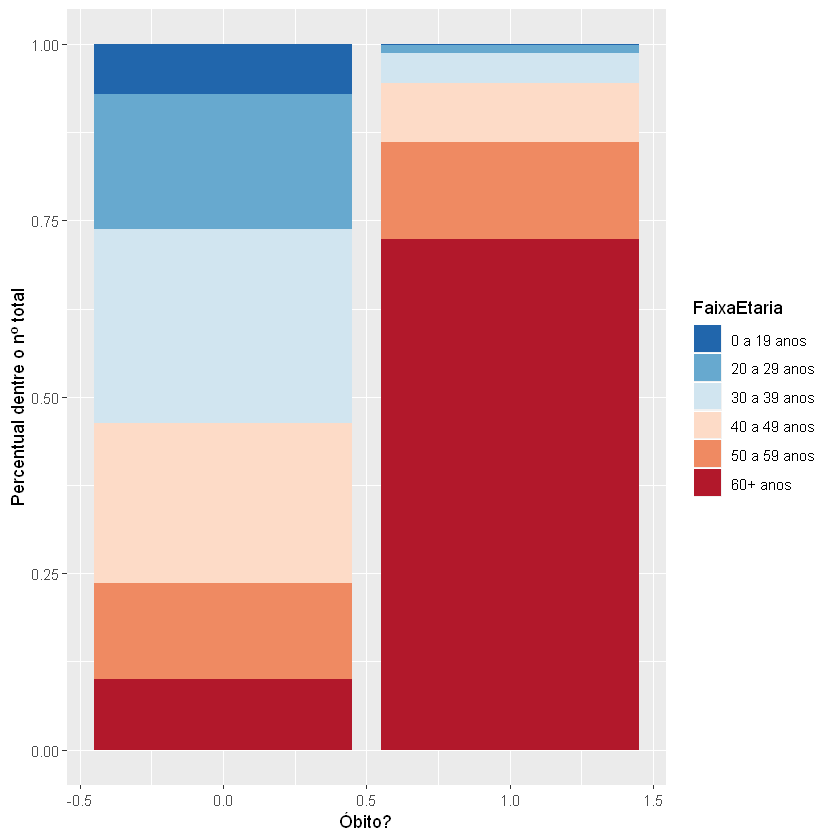

In [8]:
# Visualização gráfica.
df %>%
 ggplot(aes(x = Obito, fill = FaixaEtaria)) +
 geom_bar(position = "fill") +
 scale_fill_brewer(palette="RdBu", direction = -1) +
 labs(x = "Óbito?", y = "Percentual dentre o nº total")

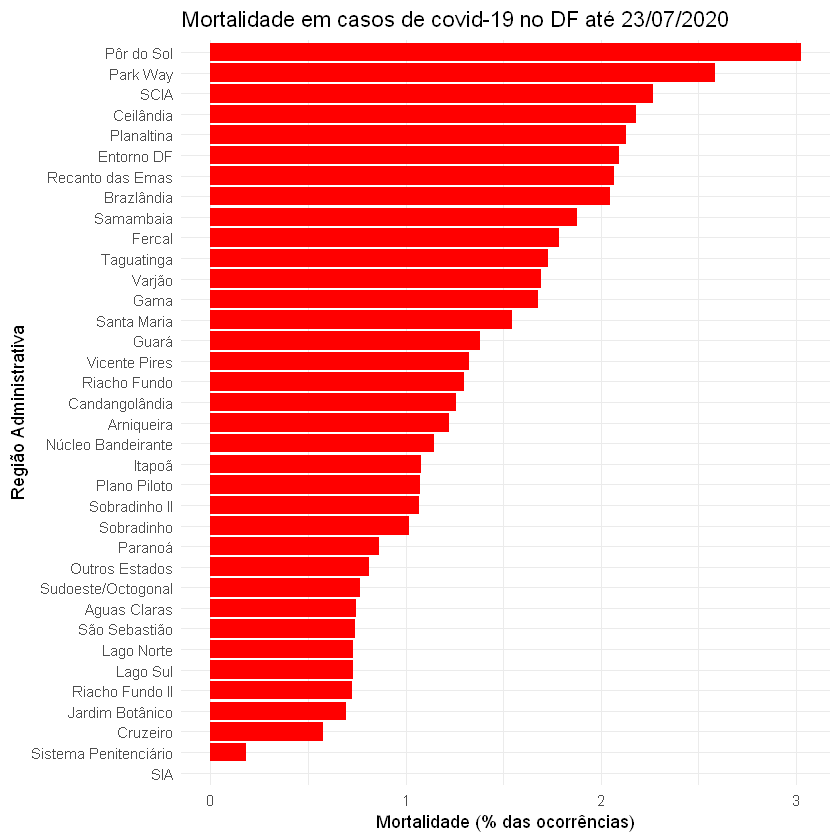

In [55]:
grouped_by_RA %>%
 filter(RA != "Não Informado") %>%
 ggplot(aes(x = reorder(RA, mortalidade), y = mortalidade * 100)) +
 geom_bar(stat = "identity", fill = "red") +
 labs(x = "Região Administrativa", y = "Mortalidade (% das ocorrências)",
      title = "Mortalidade em casos de covid-19 no DF até 23/07/2020") +
 coord_flip() +
 theme_minimal()

Por fim, o gráfico do número de casos por data, como não poderia faltar.

Warning message:
"package 'tidyquant' was built under R version 3.6.3"Loading required package: PerformanceAnalytics
Warning message:
"package 'PerformanceAnalytics' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.2"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend

Loading required package: quantmod
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
== Need to Learn tidyquant? =======================================

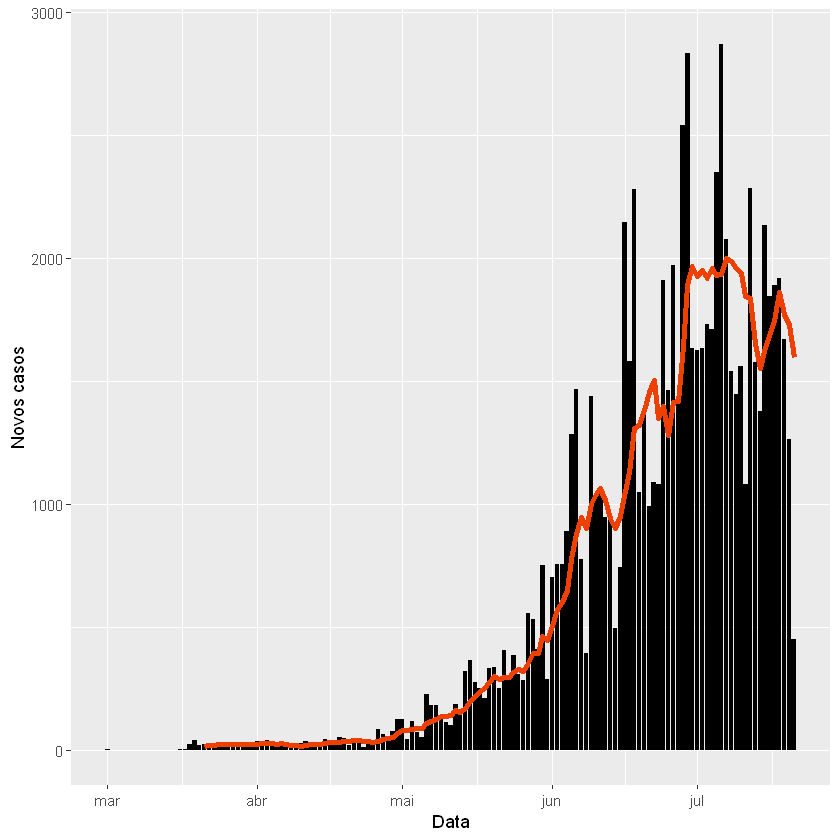

In [10]:
library(tidyquant) # Para médias móveis

# Novos casos, com média móvel para os últimos 7 dias
grouped_by_Data %>%
  #filter(!(UF %in% "")) %>%
  ggplot(aes(x = DataCadastro, y = casos)) +
  geom_bar(stat = "identity", fill = "black") +
  geom_ma(ma_fun = SMA, n = 7, color = "orangered2", size = 1.5, linetype = "solid") +  
  labs(x = "Data", y = "Novos casos")